# Energy inequality

If you care for equality, care for this analysis. Without the numbers, we won't grasp the current energy inequality. A small portion of the world is using a large portion of the energy we have, and since it is mostly from fossil fuels, it is mostly limited. Being able to regonize this, is a required step to take towards energy equality and climate justice.

This analysis can help us answer concrete questions.

> __Question:__ How much would your country need to reduce its energy consumption in order to levelize with the world average?

In this _Jupyter Notebook_, I'm going to download data, refine it, and present a graph. The graph is meant to highlight the energy inequality across the world.

Note that while you can _view_ this notebook, you can also _run_ the code within this notebook. But, what if you don't have all the tools available to do so, such as Python for example? Well, just click the link below, and _mybinder.org_ will allow you to temporarily remote control a server with everything ready.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/consideratio/climate-data-science/master?urlpath=/lab/tree/notebooks/energy_inequality.ipynb)

## My inspiration - Mathies Beckers
Thies Beckers, also known as [The Nuclear Humanist](https://www.youtube.com/channel/UClAcmfVpcKCEmHG3VrBh6-A) on YouTube, made me realize how unethical assumptions we often make. These assumptions can require energy poor inhabitants of the world to remain energy poor. There are many issues of being energy poor, but consider for example how one would need to use combustable fuels indoors for cooking, heating, and lighting. This leads to air pollution, and air pollution leads to the millions of premature deaths from indoor according to the World Health Organization. The WHO even thinks that air pollution and climate change is the biggest global health threat 2019.

Below is the video that made me realize the issue of energy inequality.

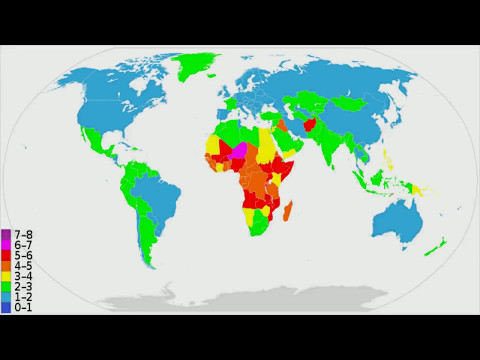

In [1]:
import IPython.display
IPython.display.YouTubeVideo(id='FARZBZAGon4', width="100%")

# The Analysis

## 1 - Get energy and population data
I'll look at 2018's energy consumption and population across the world.

The company British Petroleum (BP) is well known for the oil leak, but also for making a [_Statistical Review of World Energy_](https://bp.com/statisticalreview) that they publish yearly. This contains the kind of data I need.

In [2]:
## Download the data using the python built in library called requests
import requests
import os.path

base_url = "https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/xlsx/energy-economics/statistical-review/"
data_files = [
    "bp-stats-review-2019-all-data.xlsx",
    "bp-stats-review-2019-consolidated-dataset-narrow-format.xlsx",
]
for data_file in data_files:
    if not os.path.exists("data/" + data_file):
        r = requests.get(base_url + data_file, allow_redirects=True)
        open("data/" + data_file, 'wb').write(r.content)

## 2 - Refine the data

Before we can present a graph, we need to refine the data to what we need to present the graph I have in mind.

In [3]:
## Pandas and Numpy are goto libraries for Data Science in Python
import pandas as pd
import numpy as np

In [4]:
# NOTE: This cell takes almost a minute to execute
# Load the data from the .xlsx files into memory (Pandas dataframes)
energy = pd.read_excel("data/" + data_files[0], sheet_name=3, skiprows=2, skipfooter=11, usecols="A:BC")
population = pd.read_excel("data/" + data_files[1])

In [5]:
# Filter and rename the data frames
energy = energy.rename(columns={
    "Gigajoule per capita": "Country",
    2018: "Energy / Capita"
})
energy = energy.dropna(subset=["Country", "Energy / Capita"])

population = population[
    (population["Year"] == 2018) &
    (population["Var"] == "pop")
]
population = population.rename(columns={
    "Value": "Population",
    "SubRegion": "Sub Region"
})

In [6]:
# Merge the energy and population data frames
res = pd.merge(
    left=energy[["Country", "Energy / Capita"]],
    right=population[["Country", "Region", "Sub Region", "Population"]],
    how='outer',
    on=['Country']
)

In [7]:
# Extract world averages
tmp = res[res["Country"] == "Total World"].iloc[0]
res = res[res["Country"] != "Total World"]
world_energy_per_capita = tmp["Energy / Capita"]
world_population = tmp["Population"]

In [8]:
# Calculate energy use deviation for regions from the world's average energy use
res["Energy / Capita (offset)"] = res["Energy / Capita"] - world_energy_per_capita
res["For equality (%)"] = round((1/(res["Energy / Capita"] / world_energy_per_capita) - 1)*100, 1)

In [9]:
# Move some columns to the right in the Pandas dataframe
cols_to_move = ["Region", "Sub Region", "Population"]
new_cols = np.hstack((res.columns.difference(cols_to_move), cols_to_move))
res = res[new_cols]

In [10]:
res_country = res[~res["Country"].astype(str).str.startswith('Total')]

In [11]:
res_country[res_country["Country"] == "Turkey"]

,Country,Energy / Capita,Energy / Capita (offset),For equality (%),Region,Sub Region,Population
46,Turkey,78.47498,2.44002,-3.1,Europe,Europe,81.916871


In [12]:
res_reg = res[res["Country"].astype(str).str.startswith('Total')]
res_reg = res_reg.dropna(subset=["Energy / Capita"])
res_reg = res_reg.drop(columns=["Region", "Sub Region"])
res_reg = res_reg.rename(columns={"Country": "Region"})
res_reg["Region"] = res_reg["Region"].apply(lambda r: r[len("Total "):])

In [13]:
res_reg

,Region,Energy / Capita,Energy / Capita (offset),For equality (%),Population
3,North America,239.785968,163.751009,-68.3,494.479587
15,S. & Cent. America,56.384874,-19.650085,34.8,521.273445
50,Europe,127.372772,51.337813,-40.3,674.079399
58,CIS,160.872467,84.837507,-52.7,242.176418
68,Middle East,148.471872,72.436913,-48.8,254.438981
78,Africa,15.002966,-61.031994,406.8,1287.920538
97,Asia Pacific,60.240979,-15.793980,26.2,4160.210705


## 3 - Present a graph

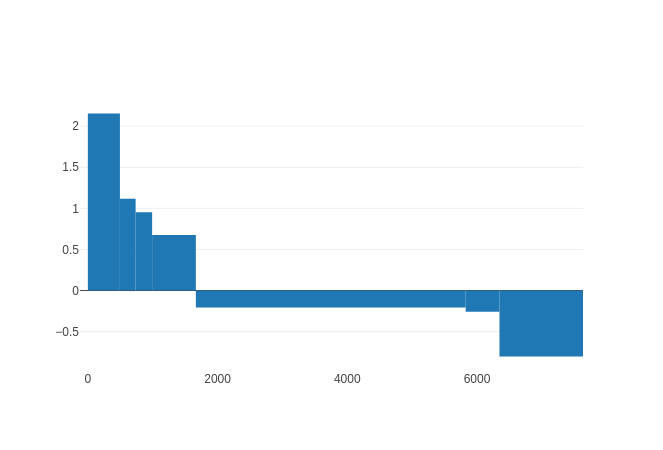

In [15]:
import plotly.offline as py
import plotly.graph_objs as go

tmp = res_reg.sort_values(by="Energy / Capita (offset)", ascending=False)

# energy / capita offset scaled in units of world energy / capita average
y = list(tmp["Energy / Capita (offset)"] / world_energy_per_capita)

# net energy change should be 0 theoretically
assert (tmp["Energy / Capita (offset)"]*tmp["Population"]).sum() < 0.0000001

# should be "Population"
width = list(tmp["Population"])

# position bars next to each other
x = [sum(width[:i]) for i in range(len(width))]

trace0 = go.Bar(
    x=x,
    y=y,
    offset=0,
    width=width
)

data = [trace0]

fig = go.Figure(data=data)
py.iplot(fig, filename='width-bar')